# Your First GAN

### Goal
In this notebook, you're going to create your first generative adversarial network (GAN) for this course! Specifically, you will build and train a GAN that can generate hand-written images of digits (0-9). You will be using PyTorch in this specialization, so if you're not familiar with this framework, you may find the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) useful. The hints will also often include links to relevant documentation.

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train your GAN and visualize the generated images.


## Getting Started
You will begin by importing some useful packages and the dataset you will use to build and train your GAN. You are also provided with a visualizer function to help you investigate the images your GAN will create.


In [1]:
import torch
from torch import nn
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28! The small size of its images makes MNIST ideal for simple training. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them (more on this later in the course).

#### Tensor
You will represent the data using [tensors](https://pytorch.org/docs/stable/tensors.html). Tensors are a generalization of matrices: for example, a stack of three matrices with the amounts of red, green, and blue at different locations in a 64 x 64 pixel image is a tensor with the shape 3 x 64 x 64.

Tensors are easy to manipulate and supported by [PyTorch](https://pytorch.org/), the machine learning library you will be using. Feel free to explore them more, but you can imagine these as multi-dimensional matrices or vectors!

#### Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.

This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated.

## Generator
The first step is to build the generator component.

You will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (you use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways. You will learn more about activations and batch normalization later in the course.

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )

Now you can build the generator class. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). You will need to fill in the code for final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">Generator</font></code></b>
</font>
</summary>

1. The output size of the final linear transformation should be im_dim, but remember you need to scale the outputs between 0 and 1 using the sigmoid function.
2. [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and [nn.Sigmoid](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html) will be useful here. 
</details>


In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [4]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.

Note that whenever you create a new tensor using torch.ones, torch.zeros, or torch.randn, you either need to create it on the target device, e.g. `torch.ones(3, 3, device=device)`, or move it onto the target device using `torch.ones(3, 3).to(device)`. You do not need to do this if you're creating a tensor by manipulating another tensor or by using a variation that defaults the device to the input, such as `torch.ones_like`. In general, use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros` where possible.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">get_noise</font></code></b>
</font>
</summary>

1. 
You will probably find [torch.randn](https://pytorch.org/docs/master/generated/torch.randn.html) useful here.
</details>

In [5]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, device=device)
    #### END CODE HERE ####

In [6]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)
    
    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.

*Note: You use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. You will learn more about this in the following lectures!* 


REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](relu-graph.png)  |  ![](lrelu-graph.png)





In [7]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
        #### END CODE HERE ####
    )

In [8]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


Now you can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [9]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator_large(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator_large, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [10]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator_med(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator_med, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [11]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator_small(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator_small, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim*2, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [12]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):

    disc_1 = Discriminator_small(z_dim, hidden_dim).get_disc()
    disc_2 = Discriminator_med(z_dim, hidden_dim).get_disc()
    disc_3 = Discriminator_large(z_dim, hidden_dim).get_disc()
    c = 1
    for disc in [disc_1, disc_2, disc_3]:
        # Check there are three parts
#         assert len(disc) == 4
        print(c)
        c+=1
        # Check the linear layer is correct
        test_input = torch.randn(num_test, z_dim)
        test_output = disc(test_input)
        assert tuple(test_output.shape) == (num_test, 1)

        # Make sure there's no sigmoid
        assert test_input.max() > 1
        assert test_input.min() < -1

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

1
2
3
1
2
3
Success!


## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



In [13]:
# Set your parameters
criterion_1 = nn.BCEWithLogitsLoss()
criterion_2 = nn.BCEWithLogitsLoss()
criterion_3 = nn.BCEWithLogitsLoss()
n_epochs = 102
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cuda:0'

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [14]:
# Generators
gen_1 = Generator(z_dim).to(device)
gen_opt_1 = torch.optim.Adam(gen_1.parameters(), lr=lr)

gen_2 = Generator(z_dim).to(device)
gen_opt_2 = torch.optim.Adam(gen_2.parameters(), lr=lr)

gen_3 = Generator(z_dim).to(device)
gen_opt_3 = torch.optim.Adam(gen_3.parameters(), lr=lr)


# Discriminators
disc_1 = Discriminator_small().to(device)
disc_opt_1 = torch.optim.Adam(disc_1.parameters(), lr=lr)

disc_2 = Discriminator_med().to(device)
disc_opt_2 = torch.optim.Adam(disc_2.parameters(), lr=lr)

disc_3 = Discriminator_large().to(device)
disc_opt_3 = torch.optim.Adam(disc_3.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [15]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     Note: Please do not use concatenation in your solution. The tests are being updated to 
    #           support this, but for now, average the two losses as described in step (4).
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake = gen(noise).detach()
    pred_fake = disc(fake)
    true_fake = torch.zeros_like(pred_fake)
    fake_loss = criterion(pred_fake, true_fake)
    
    pred_real = disc(real)
    true_real = torch.ones_like(pred_real)
    real_loss = criterion(pred_real, true_real)
    
    disc_loss = (fake_loss + real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [16]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_dim)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)
    
    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_dim)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)
    
    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))
    
def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator_med().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion_1, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05, str(disc_loss)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")

Success!


In [17]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake = gen(noise)
    pred_fake = disc(fake)
    true_fake = torch.ones_like(pred_fake)
    gen_loss = criterion(pred_fake, true_fake)
    #### END CODE HERE ####
    return gen_loss

In [18]:
def test_gen_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator_small().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion_1, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

<!-- In addition, be warned that this runs very slowly on a CPU. One way to run this more quickly is to use Google Colab: 

1.   Download the .ipynb
2.   Upload it to Google Drive and open it with Google Colab
3.   Make the runtime type GPU (under “Runtime” -> “Change runtime type” -> Select “GPU” from the dropdown)
4.   Replace `device = "cpu"` with `device = "cuda"`
5.   Make sure your `get_noise` function uses the right device -->

But remember, don’t expect anything spectacular: this is only the first lesson. The results will get better with later lessons as you learn methods to help keep your generator and discriminator at similar levels.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:
![MNIST Digits](MNIST_Progression.png)

### One generator, three discriminators

### Three generators, 3 discriminators

In [20]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: 

losses = defaultdict(list)

cur_step = 0
mean_generator_loss_1 = 0
mean_generator_loss_2 = 0
mean_generator_loss_3 = 0
mean_discriminator_loss_1 = 0
mean_discriminator_loss_2 = 0
mean_discriminator_loss_3 = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False

cutoffs = [25, 50]
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###

        disc_opt_1.zero_grad()
        disc_loss_1 = get_disc_loss(gen_1, disc_1, criterion_1, real, cur_batch_size, z_dim, device)
        disc_loss_1.backward(retain_graph=True)
        disc_opt_1.step()

        disc_opt_2.zero_grad()
        disc_loss_2 = get_disc_loss(gen_2, disc_2, criterion_2, real, cur_batch_size, z_dim, device)
        disc_loss_2.backward(retain_graph=True)
        disc_opt_2.step()

        disc_opt_3.zero_grad()
        disc_loss_3 = get_disc_loss(gen_3, disc_3, criterion_3, real, cur_batch_size, z_dim, device)
        disc_loss_3.backward(retain_graph=True)
        disc_opt_3.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights_1 = gen_1.gen[0][0].weight.detach().clone()
            old_generator_weights_2 = gen_2.gen[0][0].weight.detach().clone()
            old_generator_weights_3 = gen_3.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt_1.zero_grad()
        gen_opt_2.zero_grad()
        gen_opt_3.zero_grad()
        
        gen_loss_1 = get_gen_loss(gen_1, disc_1, criterion_1, cur_batch_size, z_dim, device)
        gen_loss_2 = get_gen_loss(gen_2, disc_2, criterion_2, cur_batch_size, z_dim, device)
        gen_loss_3 = get_gen_loss(gen_3, disc_3, criterion_3, cur_batch_size, z_dim, device)
#         gen_loss = get_gen_loss(gen, disc_2, criterion, cur_batch_size, z_dim, device)
        
        gen_loss_1.backward()
        gen_loss_2.backward()
        gen_loss_3.backward()
        
        gen_opt_1.step()
        gen_opt_2.step()
        gen_opt_3.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen_1.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen_1.gen[0][0].weight.detach().clone() != old_generator_weights_1)

                assert lr > 0.0000002 or (gen_2.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen_2.gen[0][0].weight.detach().clone() != old_generator_weights_2)
                
                assert lr > 0.0000002 or (gen_3.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen_3.gen[0][0].weight.detach().clone() != old_generator_weights_3)
                
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss_1 += disc_loss_1.item() / display_step
        mean_discriminator_loss_2 += disc_loss_2.item() / display_step
        mean_discriminator_loss_3 += disc_loss_3.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss_1 += gen_loss_1.item() / display_step
        mean_generator_loss_2 += gen_loss_2.item() / display_step
        mean_generator_loss_3 += gen_loss_3.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            losses['epochs'].append(epoch)
            losses['gen_1'].append(mean_generator_loss_1)
            losses['gen_2'].append(mean_generator_loss_2)
            losses['gen_3'].append(mean_generator_loss_3)
            losses['disc_1'].append(mean_discriminator_loss_1)
            losses['disc_2'].append(mean_discriminator_loss_2)
            losses['disc_3'].append(mean_discriminator_loss_3)
            tqdm.write(f"Epoch {epoch}, step {cur_step}: Generator losses: 1->{mean_generator_loss_1}, 2->{mean_generator_loss_2}, 3->{mean_generator_loss_3}, discriminator losses: 1->{mean_discriminator_loss_1}, 2->{mean_discriminator_loss_2}, 3->{mean_discriminator_loss_3}")
#             fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            
#             fake_1 = gen_1(fake_noise)
#             show_tensor_images(fake_1)
            
#             fake_2 = gen_2(fake_noise)
#             show_tensor_images(fake_2)
            
#             fake_3 = gen_3(fake_noise)
#             show_tensor_images(fake_3)
            
            
#             show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


  8%|▊         | 37/469 [00:01<00:14, 29.43it/s]

Epoch 1, step 500: Generator losses: 1->1.6135553739070907, 2->1.7971636993885047, 3->4.41031859207153, discriminator losses: 1->0.3319079692363736, 2->0.2774426151216028, 3->0.04543080728501076


 14%|█▍        | 67/469 [00:02<00:17, 22.94it/s]

Epoch 2, step 1000: Generator losses: 1->3.2240052278041884, 2->3.866811359882356, 3->9.293169963836668, discriminator losses: 1->0.5860574215054506, 2->0.44582701632380445, 3->0.0617270862152799


 20%|██        | 96/469 [00:04<00:16, 23.11it/s]

Epoch 3, step 1500: Generator losses: 1->4.469381072998053, 2->5.639445051908492, 3->15.33277817440033, discriminator losses: 1->0.8930746312141421, 2->0.6533979524672027, 3->0.07003182157920665


 27%|██▋       | 128/469 [00:05<00:15, 22.68it/s]

Epoch 4, step 2000: Generator losses: 1->5.524569400548942, 2->7.380433166503906, 3->23.13011345005036, discriminator losses: 1->1.2323908926844591, 2->0.8520694819390773, 3->0.07516945399402168


 34%|███▍      | 159/469 [00:06<00:13, 23.13it/s]

Epoch 5, step 2500: Generator losses: 1->6.635243615627296, 2->9.320491629362117, 3->32.070275066375764, discriminator losses: 1->1.5492722521424294, 2->1.0384886257946486, 3->0.08029746706224959


 41%|████      | 190/469 [00:06<00:09, 28.68it/s]

Epoch 6, step 3000: Generator losses: 1->7.879524657011033, 2->11.622554833173748, 3->41.56717125797275, discriminator losses: 1->1.8397713863551601, 2->1.18250760667026, 3->0.08664418684807579


 47%|████▋     | 220/469 [00:07<00:09, 25.27it/s]

Epoch 7, step 3500: Generator losses: 1->9.295476823091494, 2->14.340692680597313, 3->48.42711594963082, discriminator losses: 1->2.1068133148849033, 2->1.3044415752291667, 3->0.09700742368469917


 54%|█████▎    | 252/469 [00:10<00:09, 23.08it/s]

Epoch 8, step 4000: Generator losses: 1->10.930272377014145, 2->17.381912264585498, 3->56.707498492241015, discriminator losses: 1->2.3409533163607157, 2->1.404861777178942, 3->0.10642295600532047


 60%|██████    | 282/469 [00:12<00:08, 22.97it/s]

Epoch 9, step 4500: Generator losses: 1->12.828780149936668, 2->20.751745541334195, 3->66.7189213171006, discriminator losses: 1->2.538461620569238, 2->1.4855825393199908, 3->0.11587671176157845


 67%|██████▋   | 315/469 [00:13<00:06, 22.53it/s]

Epoch 10, step 5000: Generator losses: 1->14.828968256473528, 2->24.32429760241513, 3->74.47938003444686, discriminator losses: 1->2.734615221679221, 2->1.5608857622370107, 3->0.12397809445555288


 73%|███████▎  | 344/469 [00:14<00:05, 22.61it/s]

Epoch 11, step 5500: Generator losses: 1->16.89597584247589, 2->28.086398250341443, 3->84.38002509212505, discriminator losses: 1->2.9282775233090024, 2->1.6298121183291054, 3->0.13031457308545935


 81%|████████  | 378/469 [00:13<00:03, 28.48it/s]

Epoch 12, step 6000: Generator losses: 1->19.04828083086013, 2->31.93441889739041, 3->94.53752207851417, discriminator losses: 1->3.0983194890916432, 2->1.691650471113621, 3->0.13662289502819475


 87%|████████▋ | 407/469 [00:14<00:02, 29.45it/s]

Epoch 13, step 6500: Generator losses: 1->21.33391629362101, 2->35.86777941203117, 3->104.7828402967454, discriminator losses: 1->3.2501103674024447, 2->1.7528128955513242, 3->0.14290246607943863


 93%|█████████▎| 438/469 [00:15<00:01, 28.00it/s]

Epoch 14, step 7000: Generator losses: 1->23.62470167589181, 2->39.983744688272516, 3->114.00636885547644, discriminator losses: 1->3.410709965795287, 2->1.8156430416963978, 3->0.15104063558332567


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator losses: 1->25.960193604469232, 2->43.944529465437, 3->122.88576081657426, discriminator losses: 1->3.570728586107502, 2->1.882587506707759, 3->0.15939137152255


  7%|▋         | 33/469 [00:01<00:14, 30.33it/s]

Epoch 17, step 8000: Generator losses: 1->28.3538879723548, 2->48.0264278070927, 3->131.97234993457764, discriminator losses: 1->3.7198652249127746, 2->1.9542534099556506, 3->0.16617532242943744


 13%|█▎        | 63/469 [00:02<00:14, 28.34it/s]

Epoch 18, step 8500: Generator losses: 1->30.879934727191852, 2->52.26367702841768, 3->142.24268977355914, discriminator losses: 1->3.861101285681139, 2->2.0108952277339993, 3->0.17344007585560045


 20%|██        | 94/469 [00:03<00:13, 28.41it/s]

Epoch 19, step 9000: Generator losses: 1->33.418673838138474, 2->56.622233765363816, 3->151.2226624746318, discriminator losses: 1->3.989744551494734, 2->2.0733673137389146, 3->0.18280025689031745


 26%|██▌       | 123/469 [00:05<00:15, 23.01it/s]

Epoch 20, step 9500: Generator losses: 1->35.98215124559392, 2->60.779013370752544, 3->159.3886668977734, discriminator losses: 1->4.1219842331558665, 2->2.141442921344193, 3->0.19008453301295233


 33%|███▎      | 155/469 [00:06<00:13, 22.89it/s]

Epoch 21, step 10000: Generator losses: 1->38.62428923797599, 2->64.96386894392985, 3->168.7270566692346, discriminator losses: 1->4.247671753659868, 2->2.2088711792938445, 3->0.1973849302749877


 40%|███▉      | 186/469 [00:06<00:10, 28.16it/s]

Epoch 22, step 10500: Generator losses: 1->41.27370307588565, 2->69.04415618014353, 3->178.63889806079771, discriminator losses: 1->4.370196718245761, 2->2.2818721055947266, 3->0.20356067687313045


 46%|████▋     | 217/469 [00:07<00:10, 23.13it/s]

Epoch 23, step 11000: Generator losses: 1->43.98230456304535, 2->73.19023128724096, 3->188.82824489021226, discriminator losses: 1->4.493424039483088, 2->2.3602388061694852, 3->0.20878759808255565


 53%|█████▎    | 249/469 [00:10<00:09, 22.50it/s]

Epoch 24, step 11500: Generator losses: 1->46.75028895187355, 2->77.25613724064836, 3->197.72469287967584, discriminator losses: 1->4.623067559450875, 2->2.450401937525726, 3->0.21427017856220476


 59%|█████▉    | 279/469 [00:12<00:08, 22.77it/s]

Epoch 25, step 12000: Generator losses: 1->49.37313407468767, 2->81.18193997406954, 3->208.35133822822482, discriminator losses: 1->4.768064653053882, 2->2.536490389008087, 3->0.2200964387021013


 66%|██████▌   | 309/469 [00:13<00:07, 22.63it/s]

Epoch 26, step 12500: Generator losses: 1->52.06315780591936, 2->85.33768681979184, 3->217.8649123201362, discriminator losses: 1->4.900585894539945, 2->2.606818780582411, 3->0.22641767820763925


 73%|███████▎  | 341/469 [00:13<00:05, 22.70it/s]

Epoch 27, step 13000: Generator losses: 1->54.85122077512713, 2->89.35971431994439, 3->227.32089085102, discriminator losses: 1->5.025916697755446, 2->2.691652722109119, 3->0.23284127233458293


 79%|███████▉  | 372/469 [00:16<00:04, 22.77it/s]

Epoch 28, step 13500: Generator losses: 1->57.69399554824805, 2->93.14926414561285, 3->237.4112660741802, discriminator losses: 1->5.144230103939766, 2->2.7919878259711046, 3->0.24138383920383782


 86%|████████▌ | 402/469 [00:15<00:02, 22.76it/s]

Epoch 29, step 14000: Generator losses: 1->60.5425413479803, 2->96.95299880909943, 3->247.71029832458453, discriminator losses: 1->5.270826095104215, 2->2.897729392986749, 3->0.2569602638441503


 93%|█████████▎| 435/469 [00:18<00:01, 22.89it/s]

Epoch 30, step 14500: Generator losses: 1->63.23842696046814, 2->100.5140178596976, 3->256.50654554557747, discriminator losses: 1->5.422130062207571, 2->3.0311592008136268, 3->0.27558706717610054


 99%|█████████▉| 465/469 [00:20<00:00, 23.02it/s]

Epoch 31, step 15000: Generator losses: 1->65.94571475553502, 2->104.03480702567133, 3->263.87116699695565, discriminator losses: 1->5.5617967746257655, 2->3.16112190846727, 3->0.2899996342911982


  6%|▌         | 27/469 [00:01<00:18, 23.37it/s]

Epoch 33, step 15500: Generator losses: 1->68.52612951803216, 2->107.59757399344468, 3->272.02435239410374, discriminator losses: 1->5.722898738726971, 2->3.2913617556802994, 3->0.30228206001691477


 12%|█▏        | 57/469 [00:02<00:17, 23.89it/s]

Epoch 34, step 16000: Generator losses: 1->71.0715925431252, 2->111.12044635224368, 3->280.24216384315463, discriminator losses: 1->5.895913029864433, 2->3.4274329430721777, 3->0.3131314617729152


 19%|█▉        | 90/469 [00:03<00:16, 23.36it/s]

Epoch 35, step 16500: Generator losses: 1->73.63393396520617, 2->114.51167468047178, 3->287.938270845413, discriminator losses: 1->6.05784584234655, 2->3.578494759690024, 3->0.325713827048974


 26%|██▌       | 120/469 [00:05<00:15, 22.95it/s]

Epoch 36, step 17000: Generator losses: 1->76.07701306891428, 2->117.98603179192567, 3->295.6991288242331, discriminator losses: 1->6.239132697835567, 2->3.716587448891262, 3->0.3397813103362784


 32%|███▏      | 150/469 [00:06<00:14, 22.74it/s]

Epoch 37, step 17500: Generator losses: 1->78.46391635870918, 2->121.52450429463407, 3->303.46342116641904, discriminator losses: 1->6.430248757436872, 2->3.8478997930549195, 3->0.35871759619758087


 39%|███▉      | 183/469 [00:07<00:12, 22.30it/s]

Epoch 38, step 18000: Generator losses: 1->80.81225459837898, 2->124.9570903480056, 3->310.33071148490836, discriminator losses: 1->6.632461314067253, 2->3.9972976764850356, 3->0.3838066498741022


 45%|████▌     | 213/469 [00:09<00:11, 23.16it/s]

Epoch 39, step 18500: Generator losses: 1->83.18376297450047, 2->128.40144022870095, 3->316.385147710799, discriminator losses: 1->6.828645734652892, 2->4.151399678286158, 3->0.4122053851633312


 52%|█████▏    | 243/469 [00:10<00:09, 23.05it/s]

Epoch 40, step 19000: Generator losses: 1->85.6976511795518, 2->131.68335215973863, 3->322.9232032785399, discriminator losses: 1->7.002169732168332, 2->4.319104699578132, 3->0.4409780578307319


 59%|█████▉    | 276/469 [00:11<00:08, 22.69it/s]

Epoch 41, step 19500: Generator losses: 1->88.1260806004998, 2->134.72644848084462, 3->329.23745185279677, discriminator losses: 1->7.190532034531259, 2->4.503903478454784, 3->0.46355296812127117


 65%|██████▌   | 306/469 [00:13<00:07, 23.01it/s]

Epoch 42, step 20000: Generator losses: 1->90.55318263506872, 2->137.8239381749633, 3->335.65669183826276, discriminator losses: 1->7.394706399396079, 2->4.675529804717731, 3->0.4872416813012883


 72%|███████▏  | 336/469 [00:14<00:05, 23.12it/s]

Epoch 43, step 20500: Generator losses: 1->92.99452576088895, 2->140.98201684260383, 3->341.87002482318655, discriminator losses: 1->7.6050982619375125, 2->4.84754871600492, 3->0.5098910265469673


 79%|███████▊  | 369/469 [00:16<00:04, 22.90it/s]

Epoch 44, step 21000: Generator losses: 1->95.3455509560109, 2->144.12850206398977, 3->348.85237049579405, discriminator losses: 1->7.813051430150868, 2->5.011253785919387, 3->0.5259610871176322


 85%|████████▌ | 399/469 [00:17<00:03, 22.91it/s]

Epoch 45, step 21500: Generator losses: 1->97.71255569911003, 2->147.258124340773, 3->356.21396424865543, discriminator losses: 1->8.024563577488077, 2->5.186687904160466, 3->0.5397569831251953


 91%|█████████▏| 429/469 [00:18<00:01, 22.79it/s]

Epoch 46, step 22000: Generator losses: 1->100.062741740942, 2->150.36335973334374, 3->363.57556490993295, discriminator losses: 1->8.249180604502573, 2->5.370033335115751, 3->0.5527193984982648


 99%|█████████▊| 462/469 [00:19<00:00, 23.22it/s]

Epoch 47, step 22500: Generator losses: 1->102.42112612843509, 2->153.48206078076393, 3->370.90979729938306, discriminator losses: 1->8.457250658854875, 2->5.55309023789688, 3->0.5709474634587156


  5%|▌         | 25/469 [00:00<00:15, 29.11it/s]

Epoch 49, step 23000: Generator losses: 1->104.73253970003124, 2->156.54628428864504, 3->377.6018977928139, discriminator losses: 1->8.681200106367493, 2->5.74262564713879, 3->0.5904947021958268


 11%|█▏        | 53/469 [00:02<00:17, 23.27it/s]

Epoch 50, step 23500: Generator losses: 1->107.02048859548572, 2->159.5448076627257, 3->383.9613848533607, discriminator losses: 1->8.915759857967528, 2->5.950112355213586, 3->0.612668139003528


 18%|█▊        | 84/469 [00:03<00:15, 24.15it/s]

Epoch 51, step 24000: Generator losses: 1->109.24089919257173, 2->162.3698542926312, 3->390.8071320981958, discriminator losses: 1->9.16206949849427, 2->6.162070662315911, 3->0.6304964300546189


 25%|██▍       | 116/469 [00:04<00:13, 26.87it/s]

Epoch 52, step 24500: Generator losses: 1->111.47165744352347, 2->165.27365838885314, 3->397.739789238928, discriminator losses: 1->9.404818656489264, 2->6.355976679291555, 3->0.6405785048566964


 31%|███▏      | 147/469 [00:06<00:14, 22.84it/s]

Epoch 53, step 25000: Generator losses: 1->113.71154742240913, 2->168.12187322497374, 3->404.924907373427, discriminator losses: 1->9.646118438854817, 2->6.552574449028793, 3->0.6504091771896564


 38%|███▊      | 177/469 [00:07<00:12, 23.11it/s]

Epoch 54, step 25500: Generator losses: 1->116.05978339147575, 2->170.97189831995993, 3->412.2278380632382, discriminator losses: 1->9.864998546406634, 2->6.752024363260684, 3->0.6670776389264156


 45%|████▍     | 210/469 [00:09<00:11, 22.68it/s]

Epoch 55, step 26000: Generator losses: 1->118.3969482676983, 2->173.7530553643704, 3->418.54699627208527, discriminator losses: 1->10.093073293402798, 2->6.972773117329897, 3->0.6858457898082798


 51%|█████     | 240/469 [00:10<00:09, 22.97it/s]

Epoch 56, step 26500: Generator losses: 1->120.71929697275175, 2->176.54727490472806, 3->424.96488182926095, discriminator losses: 1->10.345686672732251, 2->7.20021089639885, 3->0.7047440092796107


 58%|█████▊    | 271/469 [00:09<00:07, 27.83it/s]

Epoch 57, step 27000: Generator losses: 1->122.94422278523452, 2->179.20193611288096, 3->431.2871837320323, discriminator losses: 1->10.60822854100167, 2->7.435044190313643, 3->0.7240226503006052


 65%|██████▌   | 305/469 [00:09<00:05, 32.12it/s]

Epoch 58, step 27500: Generator losses: 1->125.14637333297743, 2->181.79487691831636, 3->437.1782777986521, discriminator losses: 1->10.88157133547962, 2->7.68184815117342, 3->0.7500440533285371


 71%|███████   | 333/469 [00:14<00:05, 22.94it/s]

Epoch 59, step 28000: Generator losses: 1->127.32644060826321, 2->184.4719453272826, 3->442.7997180862419, discriminator losses: 1->11.148145811691904, 2->7.915453009482448, 3->0.7740300938406376


 77%|███████▋  | 363/469 [00:15<00:04, 22.90it/s]

Epoch 60, step 28500: Generator losses: 1->129.49927507591292, 2->187.2162812738427, 3->448.5488014802923, discriminator losses: 1->11.432035492643742, 2->8.15811656313758, 3->0.805484877406701


 84%|████████▍ | 395/469 [00:15<00:03, 22.76it/s]

Epoch 61, step 29000: Generator losses: 1->131.61766535544447, 2->189.78806769180372, 3->454.26492276573094, discriminator losses: 1->11.719419698819536, 2->8.405782718773887, 3->0.827748429995345


 91%|█████████ | 426/469 [00:18<00:01, 22.31it/s]

Epoch 62, step 29500: Generator losses: 1->133.79074610829437, 2->192.38785811328978, 3->459.92761425876563, discriminator losses: 1->11.993207888290303, 2->8.642128308054026, 3->0.8543106360694749


 98%|█████████▊| 459/469 [00:18<00:00, 28.18it/s]

Epoch 63, step 30000: Generator losses: 1->135.94257001257017, 2->194.92815352392304, 3->465.707561209678, discriminator losses: 1->12.276023182526238, 2->8.883075304027615, 3->0.8806934159801695


  4%|▍         | 19/469 [00:00<00:15, 29.22it/s]

Epoch 65, step 30500: Generator losses: 1->138.0345825464735, 2->197.480457227231, 3->471.4149665422435, discriminator losses: 1->12.57371606130898, 2->9.119224313165978, 3->0.9084290994595164


 11%|█         | 51/469 [00:02<00:18, 22.88it/s]

Epoch 66, step 31000: Generator losses: 1->140.20664943075303, 2->200.11143223810294, 3->476.7038339309693, discriminator losses: 1->12.8542131704539, 2->9.341068276759238, 3->0.9467548633356003


 17%|█▋        | 81/469 [00:02<00:13, 29.84it/s]

Epoch 67, step 31500: Generator losses: 1->142.28463839388024, 2->202.72609503221565, 3->481.69971849155434, discriminator losses: 1->13.153685720130799, 2->9.58085406848417, 3->0.9916077164354151


 24%|██▍       | 112/469 [00:03<00:12, 28.21it/s]

Epoch 68, step 32000: Generator losses: 1->144.33138002896476, 2->205.3502380149368, 3->486.63443605852166, discriminator losses: 1->13.455995409294921, 2->9.819489259567126, 3->1.0313998617537672


 31%|███       | 144/469 [00:05<00:11, 28.09it/s]

Epoch 69, step 32500: Generator losses: 1->146.3238407981411, 2->207.96601953911792, 3->491.4576423649792, discriminator losses: 1->13.768796866849042, 2->10.063341096218688, 3->1.0800923263959934


 37%|███▋      | 174/469 [00:07<00:13, 22.42it/s]

Epoch 70, step 33000: Generator losses: 1->148.35306772756732, 2->210.49487421035806, 3->496.24381108713277, discriminator losses: 1->14.070710332348892, 2->10.321621132370128, 3->1.1273231733532953


 43%|████▎     | 204/469 [00:08<00:11, 22.73it/s]

Epoch 71, step 33500: Generator losses: 1->150.39930513024484, 2->212.90637810254142, 3->500.7444865832343, discriminator losses: 1->14.371716646656346, 2->10.623688522573609, 3->1.178246609310465


 50%|█████     | 235/469 [00:09<00:10, 23.08it/s]

Epoch 72, step 34000: Generator losses: 1->152.354767062189, 2->215.31495050144247, 3->505.4025477666871, discriminator losses: 1->14.711371421650009, 2->10.902267302420046, 3->1.2170353156186968


 57%|█████▋    | 267/469 [00:11<00:08, 22.82it/s]

Epoch 73, step 34500: Generator losses: 1->154.33156677937689, 2->217.7780537390716, 3->510.58047080230926, discriminator losses: 1->15.046111556187237, 2->11.170310623403704, 3->1.2557918016196552


 64%|██████▍   | 300/469 [00:10<00:05, 28.31it/s]

Epoch 74, step 35000: Generator losses: 1->156.28878882312938, 2->220.20625087213588, 3->515.0739589314478, discriminator losses: 1->15.37525899295504, 2->11.440540775176201, 3->1.3024880405686168


 70%|███████   | 329/469 [00:12<00:04, 28.21it/s]

Epoch 75, step 35500: Generator losses: 1->158.34945779252192, 2->222.57570971179064, 3->519.1253475065247, discriminator losses: 1->15.676395568087669, 2->11.732642123874331, 3->1.3745058342575394


 77%|███████▋  | 359/469 [00:12<00:04, 22.96it/s]

Epoch 76, step 36000: Generator losses: 1->160.29015405607362, 2->224.83829360580498, 3->523.521127668382, discriminator losses: 1->16.0263144650012, 2->12.027137457963127, 3->1.4211044789080791


 83%|████████▎ | 391/469 [00:13<00:02, 28.29it/s]

Epoch 77, step 36500: Generator losses: 1->162.17131369567073, 2->227.0214944050321, 3->527.5578013882642, discriminator losses: 1->16.372583150580507, 2->12.334220664706127, 3->1.4913242804141063


 90%|████████▉ | 421/469 [00:17<00:02, 22.70it/s]

Epoch 78, step 37000: Generator losses: 1->164.0885189967172, 2->229.20651886773183, 3->531.6978375515948, discriminator losses: 1->16.72243553175034, 2->12.63448755764593, 3->1.5594179403887383


 97%|█████████▋| 453/469 [00:19<00:00, 22.99it/s]

Epoch 79, step 37500: Generator losses: 1->166.00480795669716, 2->231.45630062675545, 3->535.9731557765019, discriminator losses: 1->17.0544136850983, 2->12.91892065918078, 3->1.6098483448096772


  3%|▎         | 15/469 [00:00<00:18, 24.33it/s]

Epoch 81, step 38000: Generator losses: 1->167.85394148802874, 2->233.71036385369365, 3->539.9839983820924, discriminator losses: 1->17.4248742706329, 2->13.207691570755161, 3->1.6742182416388078


 10%|▉         | 45/469 [00:01<00:17, 24.63it/s]

Epoch 82, step 38500: Generator losses: 1->169.63502281165225, 2->235.90697390270287, 3->543.9825067715657, discriminator losses: 1->17.790225238338174, 2->13.51314086413018, 3->1.7408930329730048


 17%|█▋        | 78/469 [00:03<00:16, 23.03it/s]

Epoch 83, step 39000: Generator losses: 1->171.44286315536607, 2->238.05790765547795, 3->547.789816217423, discriminator losses: 1->18.14522484029836, 2->13.819615081753643, 3->1.808058628726121


 23%|██▎       | 108/469 [00:04<00:15, 23.12it/s]

Epoch 84, step 39500: Generator losses: 1->173.32475846743702, 2->240.34305621814775, 3->551.8605849733337, discriminator losses: 1->18.493163263931912, 2->14.10148641100159, 3->1.8647306441472122


 30%|██▉       | 139/469 [00:05<00:14, 23.11it/s]

Epoch 85, step 40000: Generator losses: 1->175.11797115969762, 2->242.4938966856007, 3->556.0376885809881, discriminator losses: 1->18.870725933924355, 2->14.41489464509122, 3->1.9203975971297589


 36%|███▋      | 171/469 [00:07<00:12, 22.94it/s]

Epoch 86, step 40500: Generator losses: 1->176.92732524561976, 2->244.69456722593335, 3->560.1420804667447, discriminator losses: 1->19.229510442033458, 2->14.71228830146424, 3->1.9770800078775048


 43%|████▎     | 201/469 [00:07<00:09, 28.27it/s]

Epoch 87, step 41000: Generator losses: 1->178.73503238129712, 2->246.91085008335148, 3->564.1994194302528, discriminator losses: 1->19.618923477545422, 2->15.008875901337786, 3->2.040502275299587


 50%|████▉     | 234/469 [00:08<00:08, 27.75it/s]

Epoch 88, step 41500: Generator losses: 1->180.50488410091518, 2->249.06313500261342, 3->568.081668999669, discriminator losses: 1->19.992813063397982, 2->15.319556566294347, 3->2.1076967390033707


 56%|█████▌    | 262/469 [00:10<00:09, 22.74it/s]

Epoch 89, step 42000: Generator losses: 1->182.2926996610177, 2->251.09092177891776, 3->571.805459142205, discriminator losses: 1->20.358558031007643, 2->15.65608374839655, 3->2.179486859666492


 63%|██████▎   | 296/469 [00:10<00:06, 28.21it/s]

Epoch 90, step 42500: Generator losses: 1->184.091188183547, 2->253.0887806997302, 3->575.4753123574225, discriminator losses: 1->20.721485545024265, 2->15.985534766580967, 3->2.2500893996491405


 69%|██████▉   | 324/469 [00:13<00:06, 23.10it/s]

Epoch 91, step 43000: Generator losses: 1->185.88986836671899, 2->255.15813402557416, 3->578.9048228788339, discriminator losses: 1->21.087591532632693, 2->16.302755619075196, 3->2.3357457321307953


 76%|███████▌  | 357/469 [00:15<00:04, 22.68it/s]

Epoch 92, step 43500: Generator losses: 1->187.65751167416653, 2->257.16787304997445, 3->582.3120535297354, discriminator losses: 1->21.472108685597764, 2->16.65153819077842, 3->2.417792740842637


 82%|████████▏ | 386/469 [00:17<00:03, 22.91it/s]

Epoch 93, step 44000: Generator losses: 1->189.42630427646708, 2->259.18422373962386, 3->585.5912737154923, discriminator losses: 1->21.85035673223434, 2->16.98256170671813, 3->2.5047717992554683


 89%|████████▉ | 417/469 [00:18<00:02, 22.82it/s]

Epoch 94, step 44500: Generator losses: 1->191.1764700539123, 2->261.20581348252284, 3->589.3476817517239, discriminator losses: 1->22.23974396346509, 2->17.3008913200461, 3->2.572147491965746


 96%|█████████▌| 450/469 [00:15<00:00, 30.24it/s]

Epoch 95, step 45000: Generator losses: 1->192.88586117839955, 2->263.2297050039771, 3->593.0569056277244, discriminator losses: 1->22.633498739704486, 2->17.62651773792133, 3->2.6525992798454356


  3%|▎         | 14/469 [00:00<00:15, 29.42it/s]

Epoch 97, step 45500: Generator losses: 1->194.57207874035973, 2->265.1277059812542, 3->596.5095087566353, discriminator losses: 1->23.046063342735184, 2->17.97713137808069, 3->2.736364677692133


  9%|▉         | 44/469 [00:01<00:14, 30.07it/s]

Epoch 98, step 46000: Generator losses: 1->196.24304006600516, 2->267.0699625387186, 3->600.2866925144184, discriminator losses: 1->23.447364616915614, 2->18.312472459431742, 3->2.814371151456919


 15%|█▌        | 72/469 [00:03<00:17, 22.88it/s]

Epoch 99, step 46500: Generator losses: 1->197.89318224334792, 2->269.1215727272024, 3->603.9068811655053, discriminator losses: 1->23.856822175189873, 2->18.62972936156017, 3->2.896319515290049


 22%|██▏       | 105/469 [00:04<00:16, 22.57it/s]

Epoch 100, step 47000: Generator losses: 1->199.55175471758915, 2->271.1440123381604, 3->607.5092323441514, discriminator losses: 1->24.25399180589617, 2->18.957430037107265, 3->2.9697347438152186


 29%|██▉       | 135/469 [00:05<00:14, 22.58it/s]

Epoch 101, step 47500: Generator losses: 1->201.2701358520994, 2->273.211573496817, 3->610.8525981717122, discriminator losses: 1->24.639681378588083, 2->19.271817229296964, 3->3.0626522615778504


100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


### 1 generator

### 3 generators

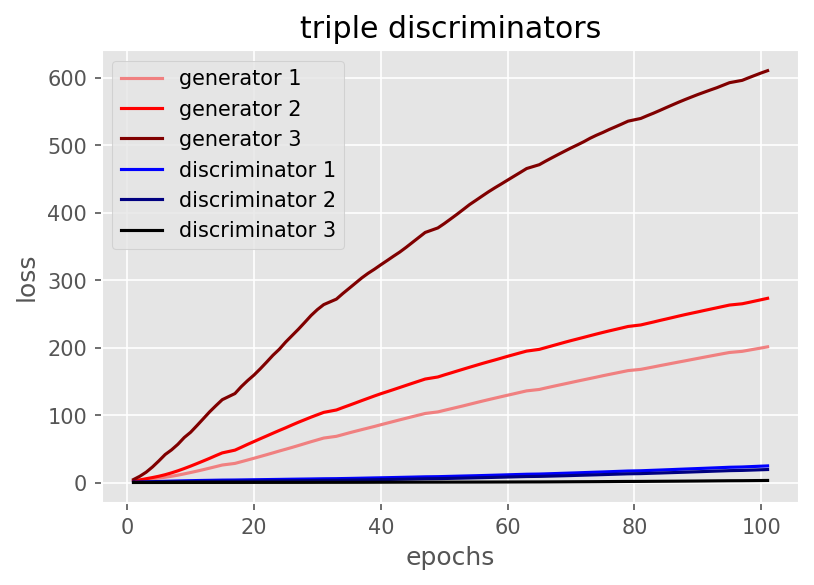

In [23]:
plt.style.use('ggplot')
plt.figure(dpi=150)
n = 150
x = losses['epochs'][:n]
plt.plot(x, losses['gen_1'][:n], 'lightcoral', label='generator 1')
plt.plot(x, losses['gen_2'][:n], 'red', label='generator 2')
plt.plot(x, losses['gen_3'][:n], 'maroon', label='generator 3')
plt.plot(x, losses['disc_1'][:n], 'b', label='discriminator 1')
plt.plot(x, losses['disc_2'][:n], 'navy', label='discriminator 2')
plt.plot(x, losses['disc_3'][:n], 'black', label='discriminator 3')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('triple discriminators')
# plt.ylim([0, 10])
plt.legend(loc='upper left')